In [1]:
%reload_kedro

2021-04-18 19:39:31,899 - root - INFO - Registered hooks from 2 installed plugin(s): kedro-mlflow-0.7.0
2021-04-18 19:39:31,915 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.


/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/kedro/framework/project/__init__.py:133: UserWarning: Found duplicate pipeline entries. The following will be overwritten: __default__
  warn(


2021-04-18 19:39:32,015 - root - INFO - ** Kedro project viabill
2021-04-18 19:39:32,016 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-04-18 19:39:32,041 - root - INFO - Registered line magic `run_viz`


In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = catalog.load('master_table')

2021-04-18 19:39:33,309 - kedro.io.data_catalog - INFO - Loading data from `master_table` (ParquetDataSet)...


# Default rate vs #clients transactions

In [4]:
df['rank'].value_counts().sort_index()

1.0     37721
2.0     74977
3.0     98478
4.0     98204
5.0     77503
6.0     50779
7.0     28516
8.0     14358
9.0      6283
10.0     2409
11.0      852
12.0      298
13.0       79
14.0       31
15.0        6
16.0        2
Name: rank, dtype: int64

In [5]:
df.loc[df['rank']>9,'rank'] = 10

2021-04-18 19:39:34,468 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


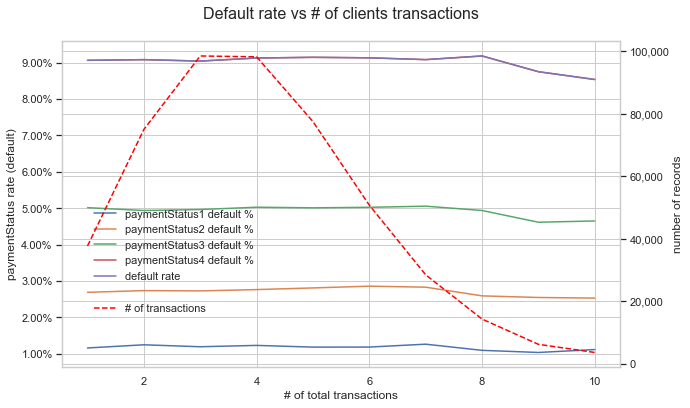

In [6]:
%matplotlib inline
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

df.assign(paymentStatus1=lambda x: x['paymentStatus1']==2).groupby('rank')['paymentStatus1'].mean().sort_index().plot(label='paymentStatus1 default %', ax=ax1)
df.assign(paymentStatus2=lambda x: x['paymentStatus2']==2).groupby('rank')['paymentStatus2'].mean().sort_index().plot(label='paymentStatus2 default %', ax=ax1)
df.assign(paymentStatus3=lambda x: x['paymentStatus3']==2).groupby('rank')['paymentStatus3'].mean().sort_index().plot(label='paymentStatus3 default %', ax=ax1)
df.assign(paymentStatus4=lambda x: x['paymentStatus4']==2).groupby('rank')['paymentStatus4'].mean().sort_index().plot(label='paymentStatus4 default %', ax=ax1)
df.groupby('rank')['default'].mean().sort_index().plot(label='default rate', ax=ax1)

df['rank'].value_counts().sort_index().plot(color='red', label='# of transactions' ,ax=ax2)

ax2.lines[0].set_linestyle("--")

ax1.legend(loc = (.05,.25), frameon = False)
ax2.legend(loc = (.05, .15), frameon = False)

ax1.set(xlabel='# of total transactions', ylabel='paymentStatus rate (default)')
ax2.set(ylabel='number of records')

plt.title('Default rate vs # of clients transactions', y=1.05, fontsize = 16)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y))) 
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 

plt.show()


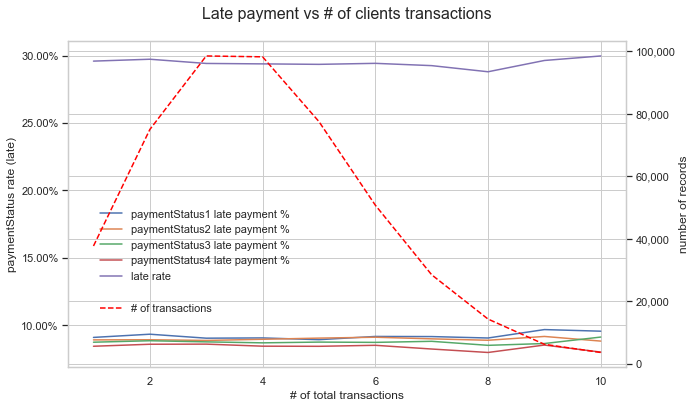

In [7]:
%matplotlib inline
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

df.assign(paymentStatus1=lambda x: x['paymentStatus1']==1).groupby('rank')['paymentStatus1'].mean().sort_index().plot(label='paymentStatus1 late payment %', ax=ax1)
df.assign(paymentStatus2=lambda x: x['paymentStatus2']==1).groupby('rank')['paymentStatus2'].mean().sort_index().plot(label='paymentStatus2 late payment %', ax=ax1)
df.assign(paymentStatus3=lambda x: x['paymentStatus3']==1).groupby('rank')['paymentStatus3'].mean().sort_index().plot(label='paymentStatus3 late payment %', ax=ax1)
df.assign(paymentStatus4=lambda x: x['paymentStatus4']==1).groupby('rank')['paymentStatus4'].mean().sort_index().plot(label='paymentStatus4 late payment %', ax=ax1)
df.groupby('rank')['late'].mean().sort_index().plot(label='late rate', ax=ax1)

df['rank'].value_counts().sort_index().plot(color='red', label='# of transactions' ,ax=ax2)

ax2.lines[0].set_linestyle("--")

ax1.legend(loc = (.05,.25), frameon = False)
ax2.legend(loc = (.05, .15), frameon = False)

ax1.set(xlabel='# of total transactions', ylabel='paymentStatus rate (late)')
ax2.set(ylabel='number of records')

plt.title('Late payment vs # of clients transactions', y=1.05, fontsize = 16)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y))) 
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 

plt.show()


# Default rate vs "pseudo time"

transaction ID is rising monotonically, I divide it into days

<AxesSubplot:xlabel='pseudo_date'>

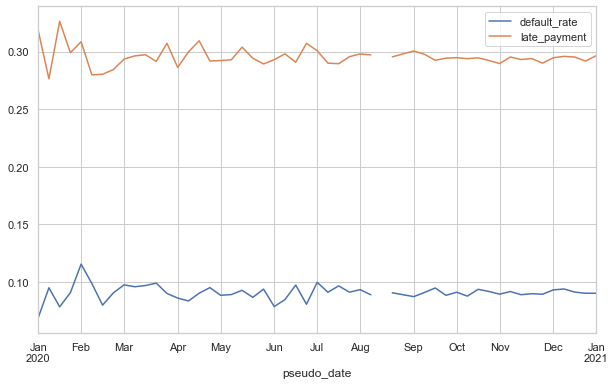

In [8]:
number_of_weeks = 52
fig, ax1 = plt.subplots(figsize=(10,6))

dates = dict([i for i in zip(range(number_of_weeks), pd.date_range(start='2020-01-01', end='2020-12-31',periods=number_of_weeks))])
div = round(df.transactionID.max()/(number_of_weeks-1),0)
df['pseudo_date'] = df.transactionID.apply(lambda x: int(round(x/div,0))).map(lambda x: dates[x])
df.set_index('pseudo_date').resample('W')[['default']].agg(default_rate=('default', 'mean')).plot(ax=ax1)
df.set_index('pseudo_date').resample('W')[['late']].agg(late_payment=('late', 'mean')).plot(ax=ax1)


# Create data splits

In [9]:
df.default.mean()

0.09094875391440502

In [10]:
df.late.mean()

0.29439995433194155

In [11]:
params_ds = catalog.load('params:data_set')

2021-04-18 19:39:47,143 - kedro.io.data_catalog - INFO - Loading data from `params:data_set` (MemoryDataSet)...


In [12]:
params_ds

{'oot': 50000, 'train': 0.7, 'test': 0.2, 'valid': 0.1}

In [13]:
df_oot = df.sort_values('customerID').iloc[-params_ds['oot']:].sort_index()
df = df.sort_values('customerID').iloc[:-params_ds['oot']]

In [14]:
size=df.shape[0]
train_size = int(size * params_ds['train'])
test_size = int(size * params_ds['test'])

df=df.sample(frac=1, random_state=1)
df_train = df.iloc[:train_size].sort_index()
df_test = df.iloc[train_size:(train_size+test_size)].sort_index()
df_valid = df.iloc[(train_size+test_size):].sort_index()


# model lightgbm - no hp, just for feature importance

In [15]:
import numpy as np
from category_encoders import *

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt 

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


In [38]:
categorical_cols = ['sex', 'residentialAddress_clean',
                    'postalAddress_clean', 'geo_risk_rank','shopID','same_address']
numerical_cols = ['age', 'income', 'price'] + \
    df.filter(regex='(^hist_)|(_lst_)').columns.to_list()
target_column = ['default']



In [51]:
lgb_params = {"seed": 42,
              "objective": "binary", 
              "learning_rate": 0.1,
              "metric":"auc"
              }

In [45]:
transformer = make_pipeline(
    ColumnTransformer([
        ('num','passthrough', numerical_cols),
        ('cat', OrdinalEncoder(), categorical_cols),    
    ]),
)

In [48]:
d_train = lgb.Dataset(
    transformer.fit_transform(df_train, df_train['default']), 
    label=df_train['default'], 
    feature_name=transformer.named_steps['columntransformer'].get_feature_names(),
    params={'verbose': -1})

d_valid = lgb.Dataset(
    transformer.transform(df_valid), 
    label=df_valid['default'], 
    feature_name=transformer.named_steps['columntransformer'].get_feature_names(),
    params={'verbose': -1})

d_test = lgb.Dataset(
    transformer.transform(df_test), 
    label=df_test['default'], 
    feature_name=transformer.named_steps['columntransformer'].get_feature_names(),
    params={'verbose': -1})

In [53]:
classifier = make_pipeline(
    ColumnTransformer([
        ('num','passthrough', numerical_cols),
        ('cat', OrdinalEncoder(), categorical_cols),       
    ]),
    LGBMClassifier(n_estimators=500, random_state=1, metric= "auc", importance_type='gain')
)

In [54]:
%%time
results=[]

for i in range(1,11): 
    _tmp_target = df.loc[df['rank']==i].reset_index(drop=True)[target_column].values.reshape(-1,)
    oof_pred = cross_val_predict(classifier, 
                                 df.loc[df['rank']==i].reset_index(drop=True), 
                                 _tmp_target, 
                                 cv=5,
                                 method="predict_proba")
    _tmp_roc_score = roc_auc_score(_tmp_target, oof_pred[:,1])
    results += [(i, _tmp_roc_score)]
    print("#{}, Cross validation AUC {:.4f}".format(i, _tmp_roc_score))

    
_tmp_target = df[target_column].values.reshape(-1,)
oof_pred = cross_val_predict(classifier, 
                             df, 
                             _tmp_target, 
                             cv=5,
                             method="predict_proba")
_tmp_roc_score = roc_auc_score(_tmp_target, oof_pred[:,1])
results += [(i, _tmp_roc_score)]
print("#ALL, Cross validation AUC {:.4f}".format(_tmp_roc_score))

#1, Cross validation AUC 0.5986
#2, Cross validation AUC 0.6127
#3, Cross validation AUC 0.6319
#4, Cross validation AUC 0.6405
#5, Cross validation AUC 0.6421
#6, Cross validation AUC 0.6290
#7, Cross validation AUC 0.6168
#8, Cross validation AUC 0.5979
#9, Cross validation AUC 0.5888
#10, Cross validation AUC 0.5864
#ALL, Cross validation AUC 0.6621
CPU times: user 10min 3s, sys: 51.2 s, total: 10min 54s
Wall time: 8min 8s


In [55]:
model = lgb.train(
    lgb_params,
    d_train,
    valid_sets=[d_train, d_valid],
    valid_names=['train', 'valid'],
)

[LightGBM] [Info] Number of positive: 28135, number of negative: 280212
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.618304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4637
[LightGBM] [Info] Number of data points in the train set: 308347, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091245 -> initscore=-2.298532
[LightGBM] [Info] Start training from score -2.298532
[1]	train's auc: 0.66714	valid's auc: 0.668299
[2]	train's auc: 0.667219	valid's auc: 0.668459
[3]	train's auc: 0.670289	valid's auc: 0.671925
[4]	train's auc: 0.670715	valid's auc: 0.671764
[5]	train's auc: 0.670937	valid's auc: 0.671649
[6]	train's auc: 0.671116	valid's auc: 0.671554
[7]	train's auc: 0.671622	valid's auc: 0.671547
[8]	train's auc: 0.672373	valid's auc: 0.672588
[9]	train's auc: 0.672422	valid's auc: 0.672736
[10]	train's auc: 0.672305	valid's auc: 0.672683
[11]	train's auc: 0.6

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

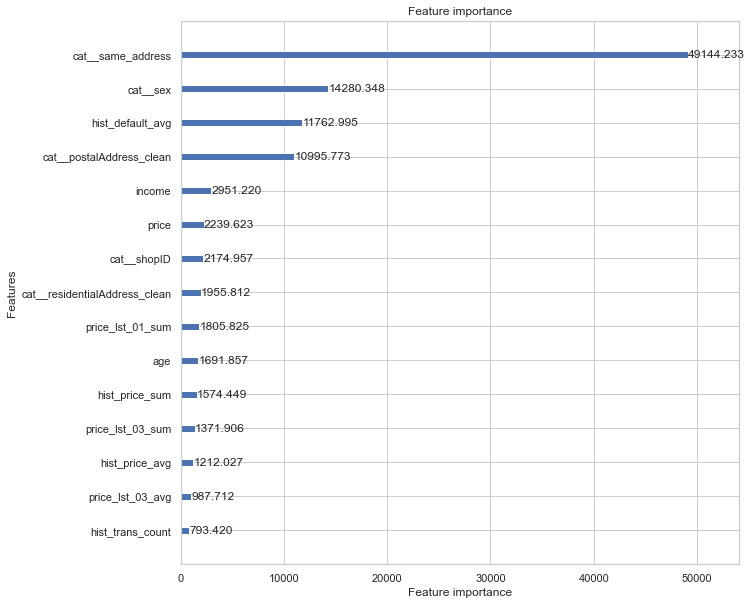

In [56]:
fig, ax2 = plt.subplots(figsize=(10,10))
lgb.plot_importance(model, max_num_features=15, ax=ax2, importance_type = 'gain')